# Record Disambiguation

In this notebook we perform entity disambiguation on records, specifically person records.

In [50]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import sys
sys.path.append("..")

from heritageconnector.disambiguation.helpers import load_training_data, plot_performance_curves, filter_top_ranked_results
from heritageconnector.disambiguation.pipelines import Disambiguator
from heritageconnector.utils.wikidata import get_sparql_results, url_to_qid
from heritageconnector.utils.generic import paginate_list
from heritageconnector.config import config

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load data
This data has already been generated using `Disambiguator.save_training_data_to_folder` and `Disambiguator.save_test_data_to_folder`.

In [2]:
train_dir = "/Volumes/Kalyan_SSD/SMG/disambiguation/people_281020/train/"
test_dir = "/Volumes/Kalyan_SSD/SMG/disambiguation/people_281020/test/"

In [3]:
X, y, pairs, pids = load_training_data(train_dir)
X_new, pairs_new, pids_new = load_training_data(test_dir)

In [4]:
pids, pids_new

(['P106', 'P569', 'P21', 'P570', 'P734', 'P735', 'label', 'P31'],
 ['P106', 'P569', 'P21', 'P570', 'P734', 'P735', 'label', 'P31'])

In [5]:
X.sum(axis=0), X_new.sum(axis=0)

(array([ 2679.        , 26567.62505612, 36153.        , 20873.14567818,
        38961.28005132, 38739.14005587, 50105.81000471, 40493.54009902]),
 array([  2174.        ,  27642.6309081 ,  78893.        ,  20711.03388381,
         96322.20012947,  72159.18014151, 114198.47994336,  96696.10330041]))

In [32]:
pairs.head()

,internal_id,wikidata_id,is_type
0,https://collection.sciencemuseumgroup.org.uk/people/cp21611,Q56181182,True
1,https://collection.sciencemuseumgroup.org.uk/people/cp21611,Q4360279,True
2,https://collection.sciencemuseumgroup.org.uk/people/cp21611,Q6792929,True
3,https://collection.sciencemuseumgroup.org.uk/people/cp21611,Q6793535,True
4,https://collection.sciencemuseumgroup.org.uk/people/cp21611,Q1911462,False


## 2. Train classifier
The disambiguator wraps `sklearn.tree.DecisionTreeClassifier` and takes its parameters as inputs.

### 2a. Test classifier performance
We'll perform a train/test split on the labelled data to quickly test the classifier's performance using its `score` method. 

The `score` method here returns [balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html): accuracy weighted so that each class is considered evenly.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [34]:
clf = Disambiguator('PERSON').fit(X_train, y_train)
for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    print(str(threshold) + " --- \n" + clf.score(X_test, y_test, threshold))

0.5 --- 
balanced accuracy score: 0.9794740146913499
precision score: 0.9054054054054054
recall score: 0.9640287769784173
0.6 --- 
balanced accuracy score: 0.9794740146913499
precision score: 0.9054054054054054
recall score: 0.9640287769784173
0.7 --- 
balanced accuracy score: 0.9794740146913499
precision score: 0.9054054054054054
recall score: 0.9640287769784173
0.8 --- 
balanced accuracy score: 0.9794740146913499
precision score: 0.9054054054054054
recall score: 0.9640287769784173
0.9 --- 
balanced accuracy score: 0.9796554699626254
precision score: 0.9115646258503401
recall score: 0.9640287769784173


### 2b. Use classifier to predict new Wikidata links

In [35]:
clf = Disambiguator('PERSON').fit(X, y)
y_pred = clf.predict(X_new, threshold=0.9)
y_pred_proba = clf.predict_proba(X_new)

print(f"{np.unique(y_pred, return_counts=True)[1][1]} potential new links found")

2431 potential new links found


In [36]:
pairs_new["y_pred"] = y_pred
pairs_new["y_pred_proba"] = y_pred_proba


The graph below shows the distribution of the number of predicted matches per SMG ID. Around 75% have a unique match, and most of the remainder have two matches.

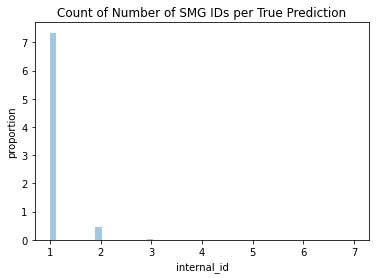

In [37]:
display(Markdown("The graph below shows the distribution of the number of predicted matches per SMG ID. Around 75% have a unique match, and most of the remainder have two matches."))
sns.distplot(pairs_new.loc[pairs_new["y_pred"] == True, "internal_id"].value_counts(), kde=False, norm_hist=True).set_ylabel('proportion')
plt.gca().set_title('Count of Number of SMG IDs per True Prediction');

## 2c. Returning top-ranked links only
We can filter some of the duplicate Wikidata candidates for each SMG item found above by _only returning the top-ranked positive matches_. `clf.predict_top_ranked_pairs` does this.

In [38]:
pairs_true = clf.predict_top_ranked_pairs(X_new, pairs_new, threshold=0.9)
print(f"No. new links: {len(pairs_true)}")
print(f"No. SMG items with new links: {len(pairs_true['internal_id'].unique())}")
pairs_true.head(20)

No. new links: 2355
No. SMG items with new links: 2271


,internal_id,wikidata_id,y_pred,y_pred_proba,is_type
54,https://collection.sciencemuseumgroup.org.uk/people/cp94357,Q75421470,True,0.960995,True
67,https://collection.sciencemuseumgroup.org.uk/people/cp17013,Q18528681,True,0.998241,True
86,https://collection.sciencemuseumgroup.org.uk/people/cp16491,Q7347877,True,0.998241,True
124,https://collection.sciencemuseumgroup.org.uk/people/cp137207,Q29554021,True,0.983339,True
386,https://collection.sciencemuseumgroup.org.uk/people/cp122042,Q8015140,True,0.998241,True
445,https://collection.sciencemuseumgroup.org.uk/people/cp83117,Q7527197,True,0.998241,True
511,https://collection.sciencemuseumgroup.org.uk/people/cp121095,Q578648,True,0.983339,True
654,https://collection.sciencemuseumgroup.org.uk/people/cp69987,Q555993,True,0.998241,True
658,https://collection.sciencemuseumgroup.org.uk/people/cp50762,Q65530095,True,0.998241,True
692,https://collection.sciencemuseumgroup.org.uk/people/cp41079,Q1726164,True,0.998241,True


## 2d. Filter matches

By type, number of links

In [51]:
max_links_per_record = 4
pairs_true_filtered = filter_top_ranked_results(pairs_true, enforce_correct_type=True, max_wikidata_links=4)

print("-- After Filtering --")
print(f"No. new links: {len(pairs_true_filtered)}")
print(f"No. SMG items with new links: {len(pairs_true_filtered['internal_id'].unique())}")


-- After Filtering --
No. new links: 2345
No. SMG items with new links: 2267


## 3. Explain classifier
We can see that the classifier prioritises P569/P570 (birth and death dates), P21 (gender), label similarity, and occupation.

It's interesting to note that P31 (instance of), which tells the classifier whether the Wikidata record is a human, is not used. This is likely because P569/P570/P106/P21 are qualities which only humans can have.

P31 is likely to be much more prevalent when classifying objects, and distinguishing between e.g. paintings and posters.

In [27]:
clf.print_tree(feature_names=pids)

|--- P569 <= 1.00
|   |--- P106 <= 0.50
|   |   |--- P570 <= 1.00
|   |   |   |--- label <= 0.99
|   |   |   |   |--- P735 <= 0.03
|   |   |   |   |   |--- class: False
|   |   |   |   |--- P735 >  0.03
|   |   |   |   |   |--- class: False
|   |   |   |--- label >  0.99
|   |   |   |   |--- P21 <= 0.50
|   |   |   |   |   |--- class: False
|   |   |   |   |--- P21 >  0.50
|   |   |   |   |   |--- class: False
|   |   |--- P570 >  1.00
|   |   |   |--- label <= 0.94
|   |   |   |   |--- class: False
|   |   |   |--- label >  0.94
|   |   |   |   |--- P734 <= 0.97
|   |   |   |   |   |--- class: False
|   |   |   |   |--- P734 >  0.97
|   |   |   |   |   |--- class: True
|   |--- P106 >  0.50
|   |   |--- label <= 0.95
|   |   |   |--- label <= 0.87
|   |   |   |   |--- P570 <= 0.28
|   |   |   |   |   |--- class: False
|   |   |   |   |--- P570 >  0.28
|   |   |   |   |   |--- class: False
|   |   |   |--- label >  0.87
|   |   |   |   |--- P569 <= 0.90
|   |   |   |   |   |--- class: 

## 4. Export model and final predictions

In [54]:
clf.save_classifier_to_disk("/Volumes/Kalyan_SSD/SMG/disambiguation/people_281020/clf.pkl")
pairs_true_filtered.to_csv("/Volumes/Kalyan_SSD/SMG/disambiguation/people_281020/people_preds_positive.csv", index=False)

You can also use the below cell to export a sample of positive and negative samples to an Excel document for manual review